# Chess in Python

Here I'll be working towards creating a chess engine using deep learning.

## Simulating Chess Matches

I want to start off by creating a chess match simulator. This will be what the engine will interact with in order to train. First thing we do here is import the necessary packages and demonstrate a bit of how they work.

In [1]:
import itertools as it

import chess
import chess.pgn

In [2]:
game = chess.pgn.Game()
board = game.board()

In [3]:
game.headers

OrderedDict([('Event', '?'),
             ('Site', '?'),
             ('Date', '????.??.??'),
             ('Round', '?'),
             ('White', '?'),
             ('Black', '?'),
             ('Result', '*')])

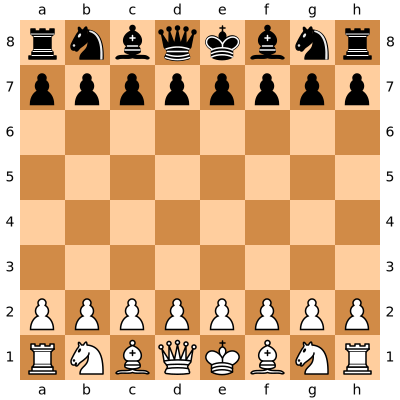

In [4]:
board

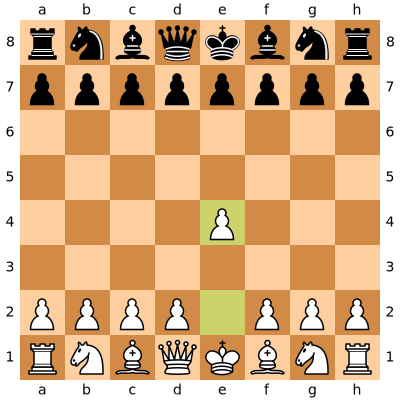

In [5]:
board.push(chess.Move.from_uci("e2e4"))
board

In [6]:
board.reset_board()

Pretty straightforward. Next we create a program that simulates random chess games where the moves are selected uniformly at random.

In [7]:
def get_current_time():
    from datetime import datetime
    return datetime.strftime(datetime.now(), "%Y/%m/%d %H:%M:%S.%f")

def initialise_game():
    game = chess.pgn.Game()
    board = game.board()
    game.headers['Date'] = get_current_time()
    game.headers['Black'] = 'Random Agent'
    game.headers['White'] = 'Random Agent'
    return game, board

def simulate_game():
    
    def get_next_move():
        from random import sample
        return sample(list(board.legal_moves), 1)[0]
        
    game, board = initialise_game()
    next_move = get_next_move()
    node = game.add_variation(next_move)
    board.push(next_move)
    while not board.is_game_over():
        next_move = get_next_move()
        node = node.add_variation(next_move)
        board.push(next_move)
    
    game.headers['Result'] = board.result()
    
    return game, board

[Event "?"]
[Site "?"]
[Date "2017/11/15 23:02:02.097958"]
[Round "?"]
[White "Random Agent"]
[Black "Random Agent"]
[Result "1/2-1/2"]

1. c3 h5 2. g4 h4 3. Nh3 Nf6 4. a4 d6 5. f4 Nh5 6. gxh5 Rh6 7. Na3 Rg6 8. a5 a6 9. d3 Rf6 10. f5 Bd7 11. Ra2 Nc6 12. Nc4 Rxf5 13. Ra4 Rf2 14. Nxf2 Ne5 15. Qc2 g5 16. Bf4 Nc6 17. Bc1 f5 18. Bf4 Nxa5 19. Ra1 Rb8 20. Ng4 Bh6 21. d4 Bc8 22. Be3 Nc6 23. Bxg5 Nxd4 24. Nf2 Nxe2 25. Be3 Ra8 26. Bb6 Qd7 27. Na5 c6 28. Ra4 Bf8 29. Bc5 Bh6 30. Nc4 h3 31. Ra3 Ra7 32. Bxd6 Qe6 33. b4 Kd7 34. Qb3 b5 35. Bxh3 Nf4+ 36. Kf1 Rb7 37. Bxe7 Qe3 38. Nd1 Ke6 39. Qa4 Kxe7 40. Nf2 Qe4 41. Ne3 Qe5 42. Bg4 Bf8 43. Qc2 Kf6 44. Nfd1 Nd3 45. h6 Rb6 46. Nf2 Nxf2 47. Qc1 Qd5 48. h3 Qe5 49. Bh5 Qd6 50. Qb2 Bg7 51. Ra2 Bd7 52. Ra4 Qg3 53. Ng2 bxa4 54. Qa2 c5 55. Qg8 Nd1 56. h7 Qf3+ 57. Bxf3 Rd6 58. bxc5 Nf2 59. Be4 Rd3 60. Bc6 Bf8 61. Bxa4 Rd1+ 62. Bxd1 Nxh3 63. Qg3 Ng1 64. Bc2 f4 65. Qh3 Bd6 66. Bf5 Bc8 67. Kxg1 Bc7 68. Bd3 Ke5 69. h8=N Bb8 70. c4 Bb7 71. Qh6 Bf3 72. Bf1 Bc7 73. Rh2 

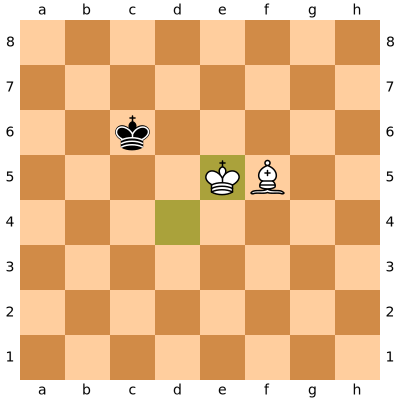

In [8]:
game, board = simulate_game()
print(game)
board

## Featurising Chess

Now that we can successfully simulate a random chess game, the next job is to turn the board position into a set of features that can be fed into a machine learning algorithm. In this part, I will take inspiration from the AlphaGo Zero model.

In [9]:
import numpy as np

We want to one-hot encode the positions of each piece on the board. As the package is written, board positions are stored using 64 bit integers. In order to repackage the board positions as a numpy array, we need to write a function to convert them.

In [10]:
def int_to_mask(squares):
    '''Takes a set of squares as an integer and returns an 8x8 matrix of the marked squares'''
    # convert int to binary
    squares = np.binary_repr(squares, width=64)
    # break int string into one-hot array
    squares = np.array([i for i in squares])
    # reshape into 8 by 8 matrix
    squares = squares.reshape(8,8)
    # flip along y axis (for some reason)
    squares = squares[:,::-1]
    # change type to int
    squares = squares.astype(np.int0)
    return squares

Now we can use `int_to_mask` to express where each piece on the board is as a numpy array.

In [11]:
int_to_mask(board.pieces_mask(color=chess.BLACK, piece_type=chess.KING))

array([[0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0]], dtype=int64)

We compare our result with the board below.

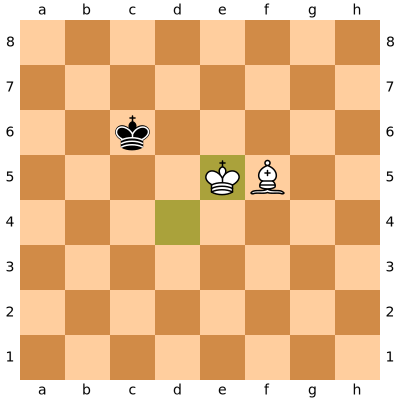

In [12]:
board

## Featurising the board position

In order to create features for the deep learning model, we will arrange the board position as a stack of `8 x 8` arrays. We will create one-hot encoded layers for each unique piece type and colour. The order of the first 12 layers will be as follows:

- White Pawn
- White Knight
- White Bishop
- White Rook
- White Queen
- White King

- Black Pawn
- Black Knight
- Black Bishop
- Black Rook
- Black Queen
- Black King

We can repeat this stack 4 times to store the past few moves on the board. This will be necessary to give the model the ability to detect 'En Passant'.

We will also add one more layer to indicate which rooks on the board are still capable of castling. And one last layer to indicate if it is the white player's turn.

That makes `12 x 4 + 2 = 50` layers over all, totalling `3200` input values.

## Building the Feature Matrix

Now I'll write the code to build the first `14` layers of the model from the game board.

In [13]:
input_data = np.zeros(shape = (14, 8, 8))
for i, colour in enumerate(chess.COLORS):
    for j, piece in enumerate(chess.PIECE_TYPES):
        k = i * len(chess.PIECE_TYPES) + j
        input_data[k, :, :] = int_to_mask(board.pieces_mask(color=colour, piece_type=piece))
        print(input_data[k, :, :])
        print()

[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]]

[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]]

[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]]

[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. 

Next we add the castling information:

In [14]:
input_data[k + 1, :, :] = int_to_mask(board.castling_rights)
input_data[k + 1, :, :]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

And lastly whose turn it is.

In [15]:
input_data[k + 2, :, :] = board.turn * np.ones((8, 8))
input_data[k + 2, :, :]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

Now we package these operations into a function that can generate the feature matrix for a given board.

In [16]:
def featurise_board(board):
    board_data = np.zeros(shape = (12, 8, 8))
    for i, colour in enumerate(chess.COLORS):
        for j, piece in enumerate(chess.PIECE_TYPES):
            k = i * len(chess.PIECE_TYPES) + j
            piece_location = board.pieces_mask(color=colour, piece_type=piece)
            board_data[k, :, :] = int_to_mask(piece_location)
    return board_data

## Defining the Foward Pass

Now that we have a sensible feature set, we have to create a model architecture, and then perform a forward pass with a random initialisation to make sure that the model output is well defined. Ideally, we would like to implement a Deep Residual Network. 

Once we have that, we will be able to start working on the Markov Chain Monte Carlo (MCMC) Tree Search implementation, and also the training loop for the model.

Some useful resources:
- https://codesachin.wordpress.com/2017/02/19/residual-neural-networks-as-ensembles/
- https://blog.waya.ai/deep-residual-learning-9610bb62c355

## What is a Move?

Before we can define the forward pass, we have define our target output. We want the model to map board positions to moves on the board, so we need a way to express what a particular move on the board looks like to the neural network.

All moves in chess are performed by selecting a piece, and moving it to a new square. At the same time that a piece is moved, there can be side-effects on the board (e.g. a piece capture, or another piece may move as in castling). This means that the target output can simply be a selection of a piece in one location, along with the target location where the piece has been moved.

This means we can represent moves via an `64 x 64 = 4096` array where moves are given as ordered pairs of squares on the board (i.e. a 'from' square to select the piece on that square and a 'target' square to select where the piece is moving).

However, we also need to add 4 more output parameters as well to describe pawn promotion. This is because when a pawn promotes to the other side of the board, the model will need to select which piece (Queen, Rook, Bishop or Knight) the AI will choose to replace the pawn. This makes for `5000` output parameters, which is quite a lot more than I would have expected.

If I can think of ways to simplify the output parameter space later, then I will. This large search space strikes me as unparsimonious.

## Coding Move Selection

Here I'll be writing the code that constructs a representation of each possible move on the board. The trick here is to do this based on the `uci` for each move.

In [17]:
# initialise the target values
move_data = np.zeros((8, 8, 8, 8))
move_data.shape

(8, 8, 8, 8)

In [18]:
def uci_to_matrix(uci):
    move_data = np.zeros((8, 8, 8, 8))
    letters = dict(zip('abcdefgh', range(8)))
    i, j, k, l = [letters[ch] if ch in letters else int(ch) for ch in uci]
    move_data[i, j, k, l] = 1
    return move_data

There is still the question of how to represent pawn promotion. In order to find out how `move.uci()` does it, I'll create a fresh board and promote a pawn in order to find out what happens.

In [19]:
board.clear_board()
board.set_piece_at(square = chess.H2,
                   piece = chess.Piece(chess.PAWN, chess.BLACK))
legal_moves = list(board.legal_moves)
legal_moves

[Move.from_uci('h2h1q'),
 Move.from_uci('h2h1r'),
 Move.from_uci('h2h1b'),
 Move.from_uci('h2h1n')]

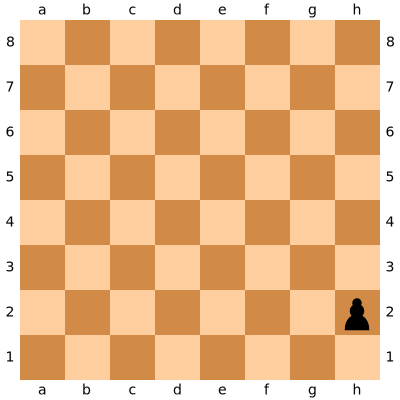

In [20]:
board

This shows us how `uci` represents pawn promotion. So all we have to do is modify the `uci_to_matrix` function to make sure this is represented as well.

In [21]:
def uci_to_array(uci):
    move_data = np.zeros((8, 8, 8, 8))
    prom_data = np.zeros(4)
    
    if len(uci) == 5:
        # handle pawn promotion
        prom_dict = dict(zip('qrbn', range(4)))
        prom_piece = prom_dict[uci[-1]]
        prom_data[prom_piece] = 1
        uci = uci[:-1]
    
    # record piece movement
    letters = dict(zip('abcdefgh', range(8)))
    i, j, k, l = [letters[ch] if ch in letters else int(ch) - 1 for ch in uci]
    move_data[i, j, k, l] = 1
    
    return move_data, prom_data

In [22]:
dict(zip('abcdefgh', range(8)))

{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7}

In [23]:
move_uci = legal_moves[0].uci()
move_data, prom_data = uci_to_array(move_uci)
move_uci

'h2h1q'

In [24]:
prom_data

array([ 1.,  0.,  0.,  0.])

In [25]:
for i, j in it.product(range(8), range(8)):
    data = move_data[i, j, :, :]
    if np.sum(data) == 1:
        print(i, j)
        print(data)

7 1
[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.]]


In [26]:
for i, j in it.product(range(8), range(8)):
    data = move_data[:, :, i, j]
    if np.sum(data) == 1:
        print(i, j)
        print(data)

7 0
[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]]


We also need to create the inverse map as well:

In [27]:
def array_to_uci(move_data, prom_data):
    i, j, k, l = np.transpose(np.nonzero(move_data))[0]
    letters = dict(zip(range(8), 'abcdefgh'))
    prom_dict = dict(zip(range(4), 'qrbn'))
    prom_piece = prom_dict[np.argmax(prom_data)]
    return letters[i] + str(j + 1) + letters[k] + str(l + 1) + prom_piece

In [28]:
array_to_uci(move_data, prom_data), move_uci

('h2h1q', 'h2h1q')

It works!

## Defining the Network Architecture

Now that we've gotten this far, it's time to have a go at creating an architecture that creates the output that we need in order to run the model.

The model architecture code is largely pulled from here, but the ideas are from the DeepMind paper:

https://blog.waya.ai/deep-residual-learning-9610bb62c355

In [29]:
import tensorflow as tf
from tensorflow.contrib.keras import layers

Here the idea is to follow the DeepMind paper closely (but with a smaller network overall). The AlphaGo Zero model consists of a single convolutional block followed by a sequence of residual blocks.

The convolutional block applies the following modules:
- A convolution of `256` filters of kernel size `3 × 3` with stride `1`
- Batch normalization
- A rectifier nonlinearity

Each residual block applies the following modules sequentially to its input:
- A convolution of `256` filters of kernel size `3 × 3` with stride `1`
- Batch normalization
- A rectifier nonlinearity
- A convolution of `256` filters of kernel size `3 × 3` with stride `1`
- Batch normalization
- A skip connection that adds the input to the block
- A rectifier nonlinearity

In [30]:
def convolutional_block(y, nb_channels, _strides=(1, 1)):
    y = layers.Conv2D(nb_channels, kernel_size=(3, 3), strides=_strides, padding='same')(y)
    y = layers.BatchNormalization()(y)
    y = layers.LeakyReLU()(y)

def residual_block(y, nb_channels, _strides=(1, 1), _project_shortcut=False):
    shortcut = y

    # down-sampling is performed with a stride of 2
    y = layers.Conv2D(nb_channels, kernel_size=(3, 3), strides=_strides, padding='same')(y)
    y = layers.BatchNormalization()(y)
    y = layers.LeakyReLU()(y)

    y = layers.Conv2D(nb_channels, kernel_size=(3, 3), strides=(1, 1), padding='same')(y)
    y = layers.BatchNormalization()(y)

    # identity shortcuts used directly when the input and output are of the same dimensions
    if _project_shortcut or _strides != (1, 1):
        # when the dimensions increase projection shortcut is used to match dimensions (done by 1×1 convolutions)
        # when the shortcuts go across feature maps of two sizes, they are performed with a stride of 2
        shortcut = layers.Conv2D(nb_channels, kernel_size=(1, 1), strides=_strides, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    y = layers.add([shortcut, y])
    y = layers.LeakyReLU()(y)

    return y

The output of the residual tower is passed into two separate ‘heads’ for
computing the policy and value. The policy head applies the following modules:
- A convolution of `2` filters of kernel size `1 × 1` with stride `1`
- Batch normalization
- A rectifier nonlinearity
- A fully connected linear layer that outputs a vector of size `192 + 1 = 362`,
corresponding to logit probabilities for all intersections and the pass move

For the last layer, we instead replace it with the target shape that we determined earlier.

In [31]:
def policy_head(y, nb_channels, _strides=(1, 1)):
    y = layers.Conv2D(nb_channels, kernel_size=(3, 3), strides=_strides, padding='same')(y)
    y = layers.BatchNormalization()(y)
    y = layers.LeakyReLU()(y)
    y = layers.Dense(units = 5000)
    return y

The value head applies the following modules:
- A convolution of `1` filter of kernel size `1 × 1` with stride `1`
- Batch normalization
- A rectifier nonlinearity
- A fully connected linear layer to a hidden layer of size `256`
- A rectifier nonlinearity
- A fully connected linear layer to a scalar
- A tanh nonlinearity outputting a scalar in the range `[−1, 1]`

In [32]:
def value_head(y, nb_channels, _strides=(1, 1)):
    y = layers.Conv2D(nb_channels, kernel_size=(3, 3), strides=_strides, padding='same')(y)
    y = layers.BatchNormalization()(y)
    y = layers.LeakyReLU()(y)
    y = layers.Dense(units = 256, activation = 'ReLU')
    y = layers.LeakyReLU()(y)
    y = layers.Dense(units = 1, activation = 'tanh')
    return y

The architecture should look something like this with some simple modifications. Before I proceed, I should make sure that this architecture works properly. Then I can work out how to train the model.

## Doing Calculations in TensorFlow

Now I need to wrap my head around how calculations in TensorFlow work. Once I can do this, I should be able to verify that my Residual Network Architecture is well defined.

Below is a simple calculation example in an interactive session:

In [33]:
sess = tf.InteractiveSession()
a = tf.constant(5.0)
b = tf.constant(6.0)
c = a * b
# We can just use 'c.eval()' without passing 'sess'
print(c.eval())
sess.close()

30.0


### Creating Input Values

In [34]:
game, board = initialise_game()

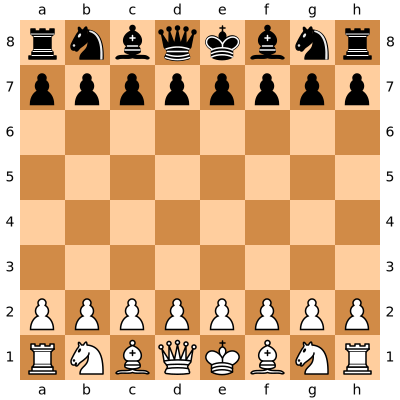

In [35]:
board

In [36]:
input_data = featurise_board(board)
input_data = input_data.reshape(1, 1, 12, 8, 8)
input_data = input_data.astype(np.float32)

In [37]:
def convolutional_block(y, nb_channels, _strides=(1, 1, 1)):
    y = layers.Conv3D(nb_channels, kernel_size=(1, 3, 3), strides=_strides, padding='same')(y)
#     y = layers.BatchNormalization()(y)
#     y = layers.LeakyReLU()(y)
    return y

In [64]:
import keras

In [70]:
sess = tf.InteractiveSession()
input_data = tf.convert_to_tensor(input_data)
# y = layers.Conv3D(filters = 256, input_shape = (1, 1, 12, 8, 8), kernel_size = (1, 3, 3), 
#                   strides = (1, 1, 1), padding='same')(input_data)
# print(y.eval())
print(keras.layers.Dense(units = 100, use_bias = False, kernel_initializer=keras.initializers.Constant(value=0)
)(input_data).eval())
sess.close()

FailedPreconditionError: Attempting to use uninitialized value dense_1_2/kernel
	 [[Node: dense_1_2/kernel/read = Identity[T=DT_FLOAT, _class=["loc:@dense_1_2/kernel"], _device="/job:localhost/replica:0/task:0/device:CPU:0"](dense_1_2/kernel)]]

Caused by op 'dense_1_2/kernel/read', defined at:
  File "c:\users\caleb\anaconda3\envs\chess-env\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\users\caleb\anaconda3\envs\chess-env\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "c:\users\caleb\anaconda3\envs\chess-env\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "c:\users\caleb\anaconda3\envs\chess-env\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "c:\users\caleb\anaconda3\envs\chess-env\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "c:\users\caleb\anaconda3\envs\chess-env\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "c:\users\caleb\anaconda3\envs\chess-env\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "c:\users\caleb\anaconda3\envs\chess-env\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "c:\users\caleb\anaconda3\envs\chess-env\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "c:\users\caleb\anaconda3\envs\chess-env\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "c:\users\caleb\anaconda3\envs\chess-env\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "c:\users\caleb\anaconda3\envs\chess-env\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "c:\users\caleb\anaconda3\envs\chess-env\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "c:\users\caleb\anaconda3\envs\chess-env\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "c:\users\caleb\anaconda3\envs\chess-env\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "c:\users\caleb\anaconda3\envs\chess-env\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "c:\users\caleb\anaconda3\envs\chess-env\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "c:\users\caleb\anaconda3\envs\chess-env\lib\site-packages\IPython\core\interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "c:\users\caleb\anaconda3\envs\chess-env\lib\site-packages\IPython\core\interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "c:\users\caleb\anaconda3\envs\chess-env\lib\site-packages\IPython\core\interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-70-a0766995d3f0>", line 7, in <module>
    )(input_data).eval())
  File "c:\users\caleb\anaconda3\envs\chess-env\lib\site-packages\keras\engine\topology.py", line 576, in __call__
    self.build(input_shapes[0])
  File "c:\users\caleb\anaconda3\envs\chess-env\lib\site-packages\keras\layers\core.py", line 830, in build
    constraint=self.kernel_constraint)
  File "c:\users\caleb\anaconda3\envs\chess-env\lib\site-packages\keras\legacy\interfaces.py", line 87, in wrapper
    return func(*args, **kwargs)
  File "c:\users\caleb\anaconda3\envs\chess-env\lib\site-packages\keras\engine\topology.py", line 400, in add_weight
    constraint=constraint)
  File "c:\users\caleb\anaconda3\envs\chess-env\lib\site-packages\keras\backend\tensorflow_backend.py", line 380, in variable
    v = tf.Variable(value, dtype=tf.as_dtype(dtype), name=name)
  File "c:\users\caleb\anaconda3\envs\chess-env\lib\site-packages\tensorflow\python\ops\variables.py", line 213, in __init__
    constraint=constraint)
  File "c:\users\caleb\anaconda3\envs\chess-env\lib\site-packages\tensorflow\python\ops\variables.py", line 356, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "c:\users\caleb\anaconda3\envs\chess-env\lib\site-packages\tensorflow\python\ops\array_ops.py", line 125, in identity
    return gen_array_ops.identity(input, name=name)
  File "c:\users\caleb\anaconda3\envs\chess-env\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 2070, in identity
    "Identity", input=input, name=name)
  File "c:\users\caleb\anaconda3\envs\chess-env\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "c:\users\caleb\anaconda3\envs\chess-env\lib\site-packages\tensorflow\python\framework\ops.py", line 2956, in create_op
    op_def=op_def)
  File "c:\users\caleb\anaconda3\envs\chess-env\lib\site-packages\tensorflow\python\framework\ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value dense_1_2/kernel
	 [[Node: dense_1_2/kernel/read = Identity[T=DT_FLOAT, _class=["loc:@dense_1_2/kernel"], _device="/job:localhost/replica:0/task:0/device:CPU:0"](dense_1_2/kernel)]]


In [51]:
input_data.shape

TensorShape([Dimension(12), Dimension(8), Dimension(8)])